In [45]:
import os
import pandas as pd
import numpy as np
import cv2
import pydicom
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from tqdm import tqdm

In [5]:
train_dir = "../../train_images"
pathology = 'scs'
df = pd.read_csv("../../dataframes/" + pathology + "_train.csv")
df['label'].value_counts()

label
0.0    8552
1.0     732
2.0     469
Name: count, dtype: int64

In [27]:
class DicomDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform
        
        # Group by study_id, series_id, and instance_number
        self.grouped_data = self.annotations.groupby(['study_id', 'series_id', 'instance_number'])
        self.keys = list(self.grouped_data.groups.keys())

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        study_id, series_id, instance_number = self.keys[idx]
        
        img_path = os.path.join(self.root_dir, str(study_id), str(series_id), f"{instance_number}.dcm")
        
        # Load DICOM
        dicom = pydicom.dcmread(img_path)
        image = dicom.pixel_array
        
        # Resize to 512x512
        image = cv2.resize(image, (512, 512))
        
        # Normalize
        image = (image - image.min()) / (image.max() - image.min())
        
        # Create mask
        mask = np.zeros((512, 512))
        
        # Get all coordinates for this instance
        instance_data = self.grouped_data.get_group((study_id, series_id, instance_number))
        
        for _, row in instance_data.iterrows():
            x = int(row['x'] * 512 / dicom.Columns)
            y = int(row['y'] * 512 / dicom.Rows)
            cv2.circle(mask, (x, y), 20, 1, -1)
        
        # Convert to tensor
        image = torch.from_numpy(image).float().unsqueeze(0)
        mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

torch.Size([8, 1, 512, 512])


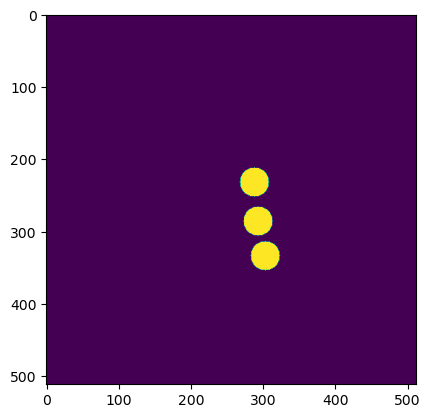

In [39]:
dataset = DicomDataset(df, root_dir=train_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

for dat in dataloader:
    img, msk = dat
    print(img.shape)
    plt.imshow(msk[0,0])
    break

In [40]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder (downsampling)
        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bridge
        self.bridge = self.conv_block(512, 1024)
        
        # Decoder (upsampling)
        self.dec4 = self.upconv(1024, 512)
        self.upconv4 = self.conv_block(1024, 512)
        self.dec3 = self.upconv(512, 256)
        self.upconv3 = self.conv_block(512, 256)
        self.dec2 = self.upconv(256, 128)
        self.upconv2 = self.conv_block(256, 128)
        self.dec1 = self.upconv(128, 64)
        self.upconv1 = self.conv_block(128, 64)
        
        self.final = nn.Conv2d(64, 1, kernel_size=1)
        
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def upconv(self, in_ch, out_ch):
        return nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.MaxPool2d(2)(e1))
        e3 = self.enc3(nn.MaxPool2d(2)(e2))
        e4 = self.enc4(nn.MaxPool2d(2)(e3))
        
        # Bridge
        b = self.bridge(nn.MaxPool2d(2)(e4))
        
        # Decoder
        d4 = self.dec4(b)
        d4 = self.upconv4(torch.cat([d4, e4], dim=1))
        d3 = self.dec3(d4)
        d3 = self.upconv3(torch.cat([d3, e3], dim=1))
        d2 = self.dec2(d3)
        d2 = self.upconv2(torch.cat([d2, e2], dim=1))
        d1 = self.dec1(d2)
        d1 = self.upconv1(torch.cat([d1, e1], dim=1))
        
        return torch.sigmoid(self.final(d1))

In [83]:
dataset = DicomDataset(df, root_dir=train_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)
total_size = len(dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # Remaining 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4)

transform = transforms.Compose([
    
])

In [55]:
from monai.losses import DiceLoss
diceloss = DiceLoss()

class LogCoshDiceLoss(nn.Module):
    """
    L_{lc-dce} = log(cosh(DiceLoss)
    """
    def __init__(self, use_softmax=True):
        super(LogCoshDiceLoss, self).__init__()
        self.use_softmax = use_softmax

    def forward(self, output, target, epsilon=1e-6):
        
        return torch.log(torch.cosh(diceloss(output, target)))

lcdice = LogCoshDiceLoss()

In [70]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = LogCoshDiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [71]:
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss
    train_loss /= len(train_loader)
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(val_loader):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
    
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}/{num_epochs}| Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}')

  0%|          | 0/253 [00:00<?, ?it/s]

100%|██████████| 64/64 [00:15<00:00,  4.20it/s]


Epoch 1/100| Train Loss: 0.2947 | Validation Loss: 0.2274


100%|██████████| 64/64 [00:14<00:00,  4.28it/s]


Epoch 2/100| Train Loss: 0.1256 | Validation Loss: 0.0656


100%|██████████| 64/64 [00:14<00:00,  4.32it/s]


Epoch 3/100| Train Loss: 0.0554 | Validation Loss: 0.0562


100%|██████████| 64/64 [00:14<00:00,  4.31it/s]


Epoch 4/100| Train Loss: 0.0475 | Validation Loss: 0.0525


100%|██████████| 64/64 [00:14<00:00,  4.35it/s]


Epoch 5/100| Train Loss: 0.0436 | Validation Loss: 0.0438


100%|██████████| 64/64 [00:14<00:00,  4.35it/s]


Epoch 6/100| Train Loss: 0.0473 | Validation Loss: 0.0454


 42%|████▏     | 107/253 [01:05<01:28,  1.64it/s]


KeyboardInterrupt: 

In [79]:
model.eval()
dice_scores = []


with torch.no_grad():
    for images, masks in tqdm(val_loader):
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()  # Threshold at 0.5

        for pred, target in zip(predicted, masks):
            # print(pred.shape, target.shape)
            dice = diceloss(pred.cpu(), target.cpu())
            dice_scores.append(1-dice)

print(np.mean(dice_scores))

100%|██████████| 64/64 [00:14<00:00,  4.32it/s]

0.79398775


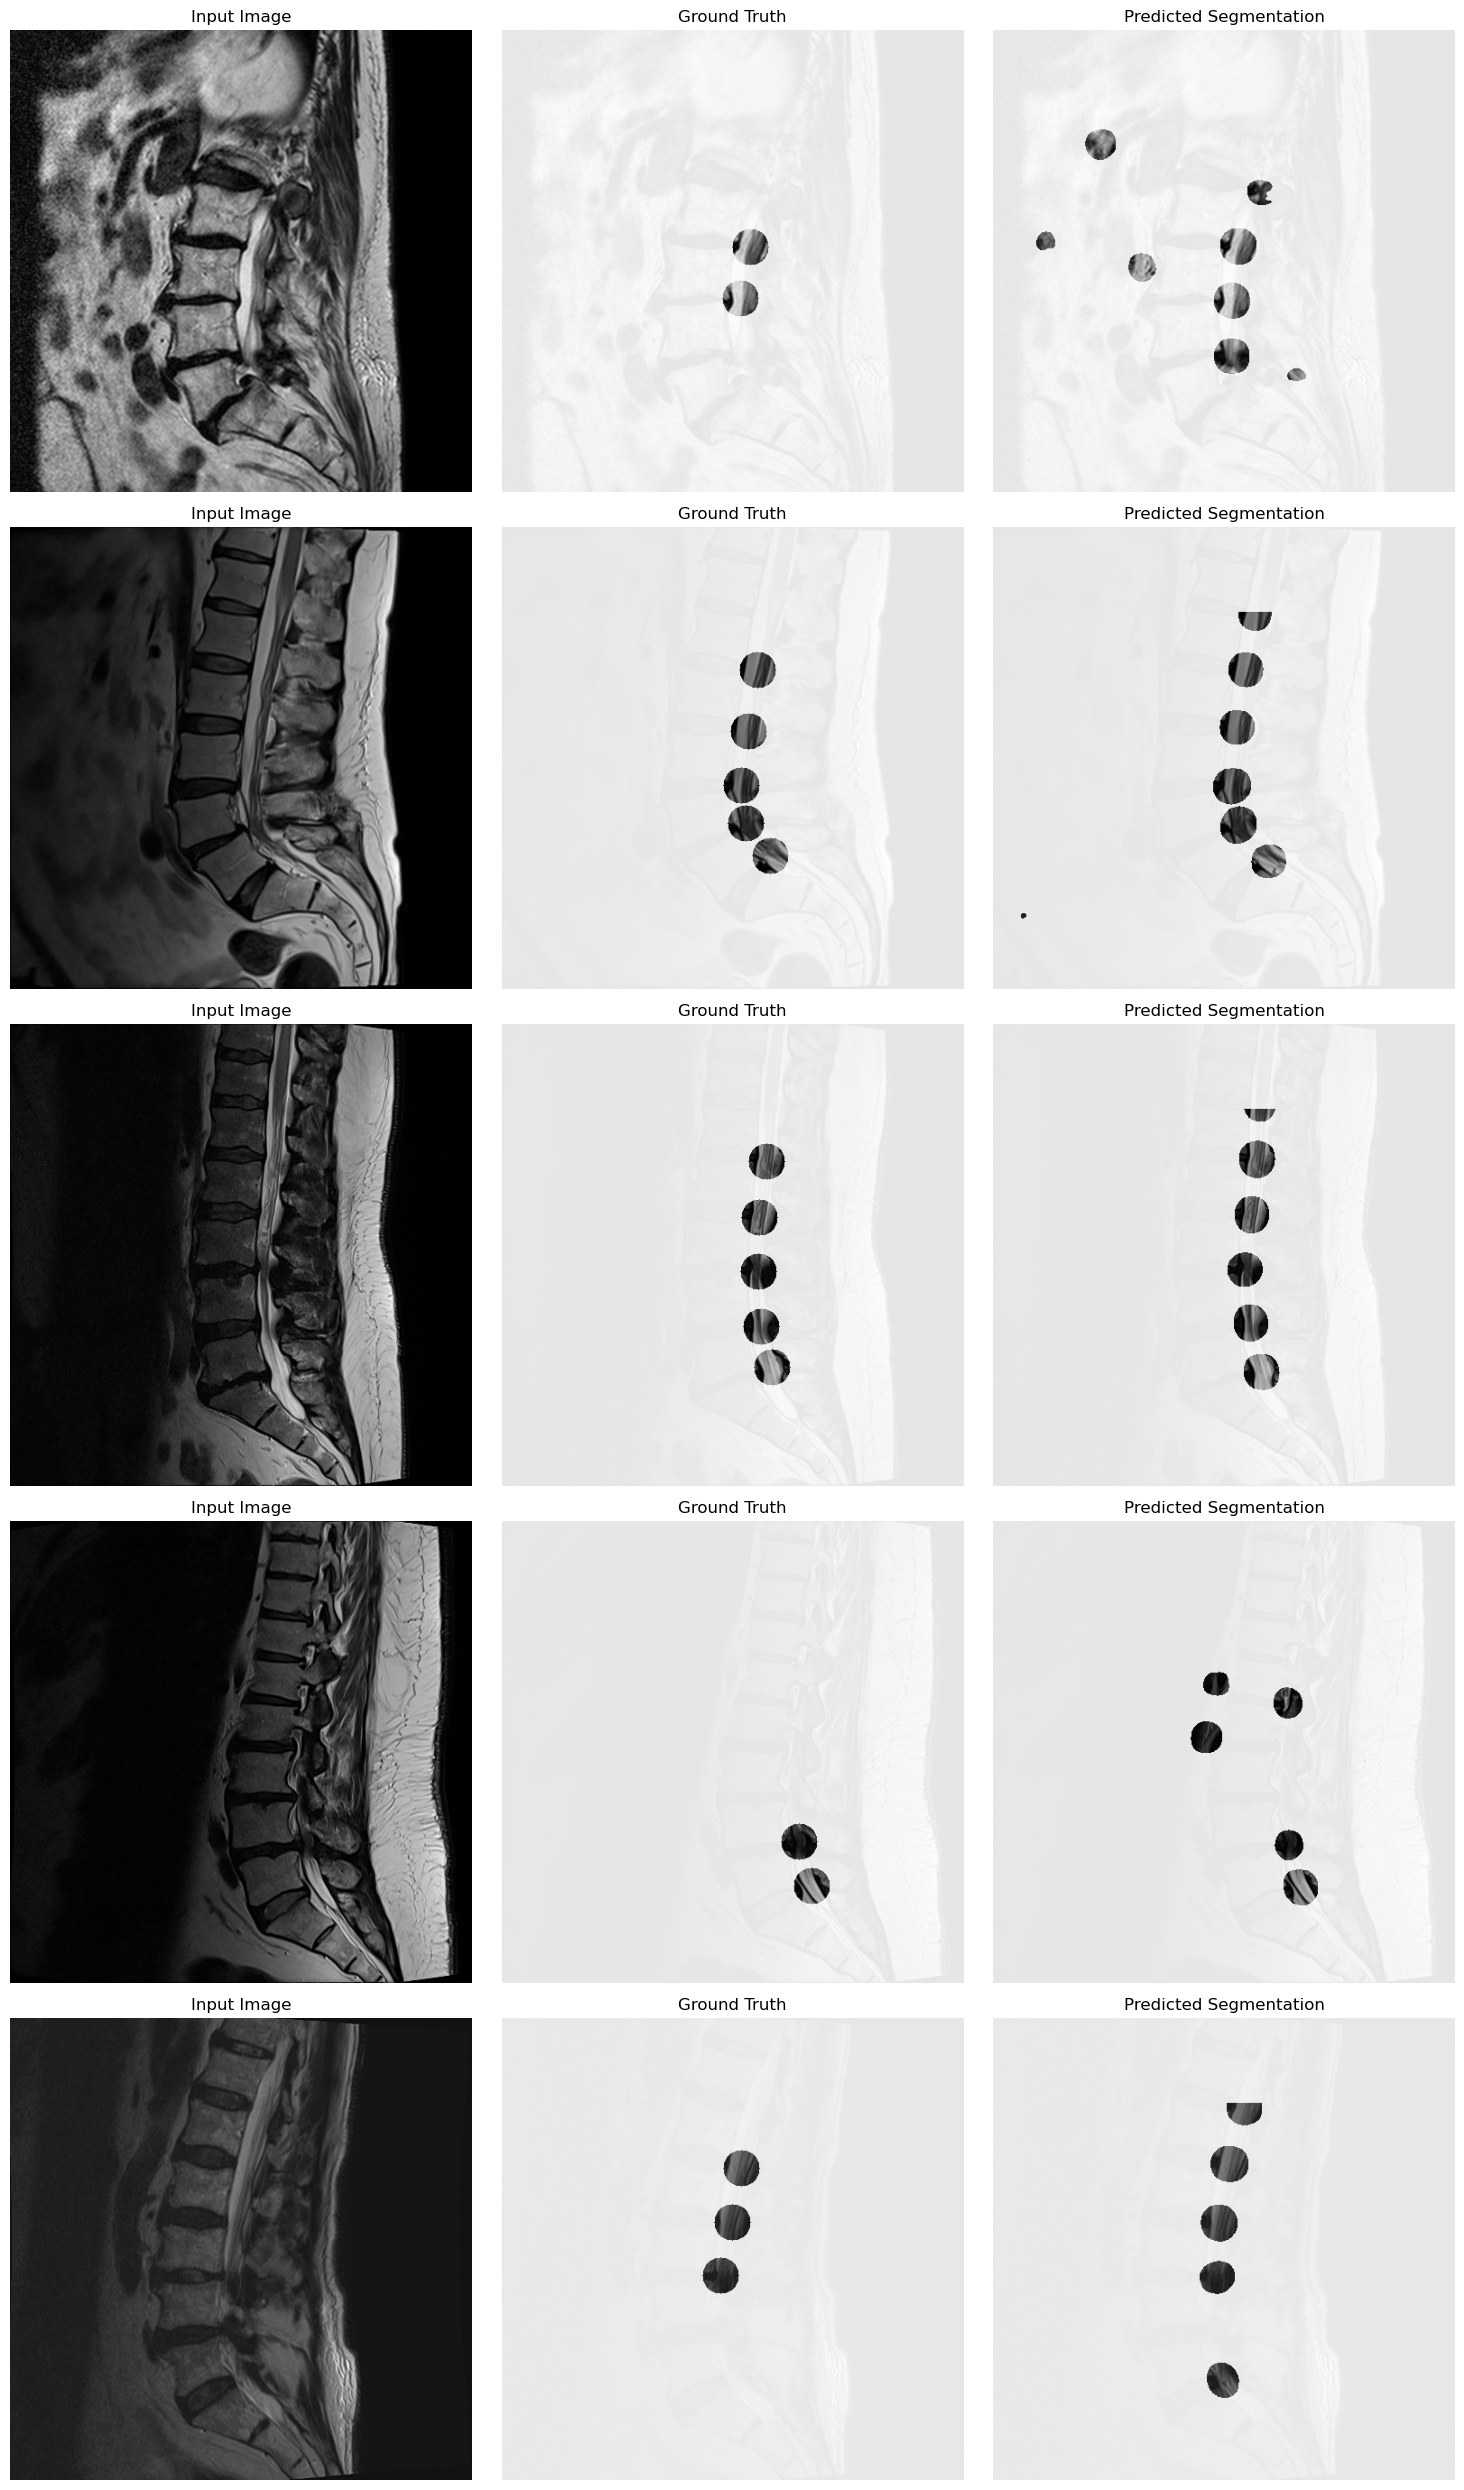

In [84]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def visualize_segmentation(model, dataloader, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(dataloader):
            if i >= num_samples:
                break
            
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            
            # Convert tensors to numpy arrays
            image = images[0, 0].cpu().numpy()
            true_mask = masks[0, 0].cpu().numpy()
            pred_mask = predicted[0, 0].cpu().numpy()
            
            # Normalize image to [0, 1] for visualization
            image = (image - image.min()) / (image.max() - image.min())
            
            # Plot original image
            axes[i, 0].imshow(image, cmap='gray')
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            # Create highlighted ground truth
            highlighted_true = np.zeros((image.shape[0], image.shape[1], 4))
            highlighted_true[:,:,0:3] = np.expand_dims(image, axis=2).repeat(3, axis=2)  # RGB channels
            highlighted_true[:,:,3] = 0.1  # Alpha channel, mostly transparent
            highlighted_true[:,:,3][true_mask == 1] = 1  # Fully opaque where mask is 1
            
            # Plot highlighted ground truth
            axes[i, 1].imshow(highlighted_true)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            # Create highlighted prediction
            highlighted_pred = np.zeros((image.shape[0], image.shape[1], 4))
            highlighted_pred[:,:,0:3] = np.expand_dims(image, axis=2).repeat(3, axis=2)  # RGB channels
            highlighted_pred[:,:,3] = 0.1  # Alpha channel, mostly transparent
            highlighted_pred[:,:,3][pred_mask == 1] = 1  # Fully opaque where mask is 1
            
            # Plot highlighted prediction
            axes[i, 2].imshow(highlighted_pred)
            axes[i, 2].set_title('Predicted Segmentation')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_segmentation(model, val_loader, device, num_samples=5)
